In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import missingno as msno  

import dabl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("loan_train.csv")
test_df = pd.read_csv('loan_test.csv')

In [3]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [5]:
print("Train data size:",train_df.shape)
print("Test data size:",test_df.shape)

Train data size: (614, 13)
Test data size: (367, 12)


In [6]:
train_df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [7]:
# check the missing values in train data
train_df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
# check the missing values in test data
test_df.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

- From the above analysis we can see even if "Dependents" is numaric, but still dtypes is "object". So this needs further exploration.
- In train and test dataset each catagorical variable needs to check which kind of data is present and do they needs to fit together or not for encoding. This needs further EDA.

In [9]:
# see the train dataset with pandas_profiling
train_report = ProfileReport(train_df)
train_report.to_file("train_report.html")

In [10]:
# see the test dataset with pandas_profiling
test_report = ProfileReport(test_df)
test_report.to_file("test_report.html")

## Feature Engineering:

### 1.1 Missing value imputation in Train Data:

From the generated profile report we can see that 
- **"Dependents"** has "3+" catagory and because of this it is identified as "object" datatype. 
    - Since it is kind of catagorical variable of how many children. Impute it with mode.
    - Change this to value 3 for genaralisation
    - Convert the datatypes to numerical
- **"Gender"** has 2 catagory: Male and Female. 
    - Lets impute the missing values with mode as it is catagorical.
- **"Married"** has 2 catagory: Yes and No
    - Lets impute the missing values with mode as it is catagorical.
- **"Self_Employed"** has 2 catagory: Yes and No
    - Lets impute the missing values with mode as it is catagorical.
- **"LoanAmount"** is a continues numerical. But from Histogram plot we can see some outlier. 
    - So impute the missing values with median
- **"Loan_Amount_Term"** is a continues numerical. From Histogram, Statistics and Common values we ca find that
    - There is some outlier and from skewness, we can tell it is negatively skewed.
    - Also 83.4% data concentrated in value 360, which is the median value.
    - So impute the missing value with median.
- **"Credit_History"** is Boolean, which is kind of catagorical. 
    - So impute it with mode.

In [11]:
train_df.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [12]:
# changing "3+" to 3 in "Dependents"
train_df['Dependents'].replace({'3+' : 3},inplace=True)

# Impute "Dependents" with mode
train_df['Dependents'].fillna(train_df['Dependents'].mode()[0],inplace=True)

train_df.Dependents.value_counts()

0    360
1    102
2    101
3     51
Name: Dependents, dtype: int64

In [13]:
# change the datatype of "Dependents" from object to numeric
train_df['Dependents']= pd.to_numeric(train_df['Dependents'])
train_df.Dependents.dtype

dtype('int64')

In [14]:
# Impute "Gender" with mode
train_df['Gender'].fillna(train_df['Gender'].mode()[0],inplace=True)
train_df.Gender.value_counts()

Male      502
Female    112
Name: Gender, dtype: int64

In [15]:
# Impute "Married" with mode
train_df['Married'].fillna(train_df['Married'].mode()[0],inplace=True)
train_df.Married.value_counts()

Yes    401
No     213
Name: Married, dtype: int64

In [16]:
# Impute "Self_Employed" with mode
train_df['Self_Employed'].fillna(train_df['Self_Employed'].mode()[0],inplace=True)
train_df.Self_Employed.value_counts()

No     532
Yes     82
Name: Self_Employed, dtype: int64

In [17]:
# Impute "Credit_History" with mode
train_df['Credit_History'].fillna(train_df['Credit_History'].mode()[0],inplace=True)
train_df.Credit_History.value_counts()

1.0    525
0.0     89
Name: Credit_History, dtype: int64

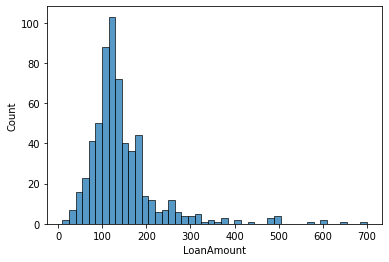

In [18]:
# Impute "LoanAmount" with median
train_df['LoanAmount'].fillna(train_df['LoanAmount'].median(),inplace=True)
sns.histplot(train_df.LoanAmount);

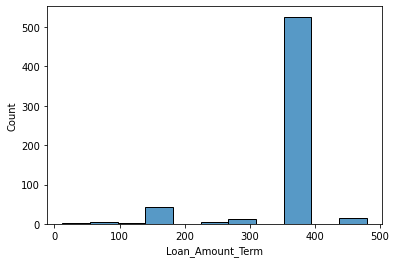

In [19]:
# Impute "Loan_Amount_Term" with median
train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].median(),inplace=True)
sns.histplot(train_df.Loan_Amount_Term);

In [20]:
# Since in the dataset Loan_ID is not important, so we are dropping it
train_df.drop(columns=['Loan_ID'],inplace=True)

In [21]:
# check the whole train data if there is any missing values
train_df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [22]:
train_df.dtypes

Gender                object
Married               object
Dependents             int64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

**--------------------------------------------------------------------------------------------------------------**

### 1.2 Missing value imputation in Test data

In [23]:
# check the NaN values and find the feature which has missing values
missing_value_feature = test_df.isnull().sum()[test_df.isnull().sum()>0]
missing_value_feature

Gender              11
Dependents          10
Self_Employed       23
LoanAmount           5
Loan_Amount_Term     6
Credit_History      29
dtype: int64

In [24]:
test_df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object

From the generated profile report for test data we can see that 
- **"Dependents"** has "3+" catagory and because of this it is identified as "object" datatype. 
    - Since it is kind of catagorical variable of how many children. Impute it with mode.
    - Change this to value 3 for genaralisation
    - Convert the datatypes to numerical
- **"Gender"** has 2 catagory: Male and Female. 
    - Lets impute the missing values with mode as it is catagorical.
- **"Self_Employed"** has 2 catagory: Yes and No
    - Lets impute the missing values with mode as it is catagorical.
- **"LoanAmount"** is a continues numerical. But from Histogram plot we can see some outlier. 
    - So impute the missing values with median
- **"Loan_Amount_Term"** is a continues numerical. From Histogram, Statistics and Common values we ca find that
    - There is some outlier and from skewness, we can tell it is negatively skewed.
    - Also 84.7% data concentrated in value 360, which is the median value.
    - So impute the missing value with median.
- **"Credit_History"** is Boolean, which is kind of catagorical. 
    - So impute it with mode.

In [25]:
# Impute "Dependents" with mode
test_df['Dependents'].fillna(test_df['Dependents'].mode()[0],inplace=True)

# changing "3+" to 3 in "Dependents"
test_df['Dependents'].replace({'3+' : 3},inplace=True)

# change the datatype of "Dependents" from object to numeric
test_df['Dependents']= pd.to_numeric(test_df['Dependents'])

# Impute "Gender" with mode
test_df['Gender'].fillna(test_df['Gender'].mode()[0],inplace=True)

# Impute "Self_Employed" with mode
test_df['Self_Employed'].fillna(test_df['Self_Employed'].mode()[0],inplace=True)

# Impute "Credit_History" with mode
test_df['Credit_History'].fillna(test_df['Credit_History'].mode()[0],inplace=True)

# Impute "LoanAmount" with median
test_df['LoanAmount'].fillna(test_df['LoanAmount'].median(),inplace=True)

# Impute "Loan_Amount_Term" with median
test_df['Loan_Amount_Term'].fillna(test_df['Loan_Amount_Term'].median(),inplace=True)

In [26]:
# Since "Loan_ID" has no importance and it is the unique id for the loan application. So drop it.
test_df.drop(columns="Loan_ID",inplace=True)

In [27]:
# check the missing values test data again
test_df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

**#################################################################################################################**

### 2. Label Encode catagorical feature in Train and Test Dataset

In [28]:
# Encode all the catagorical variable
le = LabelEncoder()

# get the feature name columns which has object type 
obj_feature = train_df.dtypes[train_df.dtypes == object].index

for obj in obj_feature:
    #fit the dataset for encoding
    le.fit(train_df[obj])
    
    #transform or encode the training data
    train_df[obj] = le.transform(train_df[[obj]])
    
    #transform or encode the test data except "Loan_Status"
    if(obj != "Loan_Status"):
        test_df[obj] = le.transform(test_df[obj])


In [29]:
# view encoded training data
train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,128.0,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


In [30]:
# view ecoded test data
test_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,1,0,0,0,5720,0,110.0,360.0,1.0,2
1,1,1,1,0,0,3076,1500,126.0,360.0,1.0,2
2,1,1,2,0,0,5000,1800,208.0,360.0,1.0,2
3,1,1,2,0,0,2340,2546,100.0,360.0,1.0,2
4,1,0,0,1,0,3276,0,78.0,360.0,1.0,2


**##################################################################################################################**

### 3. Visualise the continues variables of Training and Testing data. Select feature.

**# Continues features are "ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"**

In [31]:
# Histogram to visualise the data distribution

def hist_plot(df,title):
    fig=plt.figure(figsize=(18,8))
    plt.subplot(2,2,1)
    sns.histplot(df.ApplicantIncome)

    plt.subplot(2,2,2)
    sns.histplot(df.CoapplicantIncome)

    plt.subplot(2,2,3)
    sns.histplot(df.LoanAmount)

    plt.subplot(2,2,4)
    sns.histplot(df.Loan_Amount_Term)
    fig.suptitle(title,fontsize=20)
    

In [32]:
# Box Plot to visualise the outlier in the data

def box_plot(df,title):
    fig = plt.figure(figsize=(18,7))
    plt.subplot(2,2,1)
    sns.boxplot(x="ApplicantIncome",data=df)

    plt.subplot(2,2,2)
    sns.boxplot(x="CoapplicantIncome",data=df)

    plt.subplot(2,2,3)
    sns.boxplot(x="LoanAmount",data=df)

    plt.subplot(2,2,4)
    sns.boxplot(x="Loan_Amount_Term",data=df)
    fig.suptitle(title,fontsize=20)
    

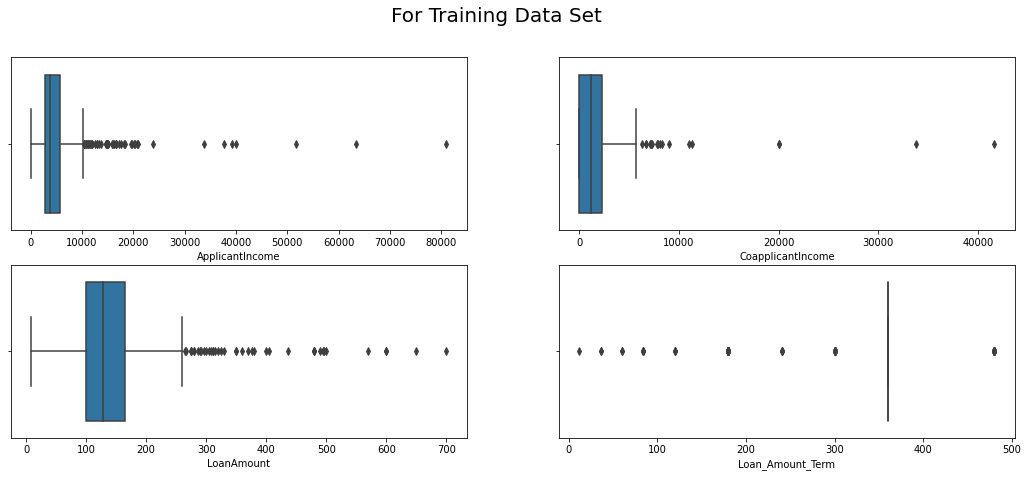

In [33]:
# Box plot for training data for continues feature
box_plot(train_df,"For Training Data Set")

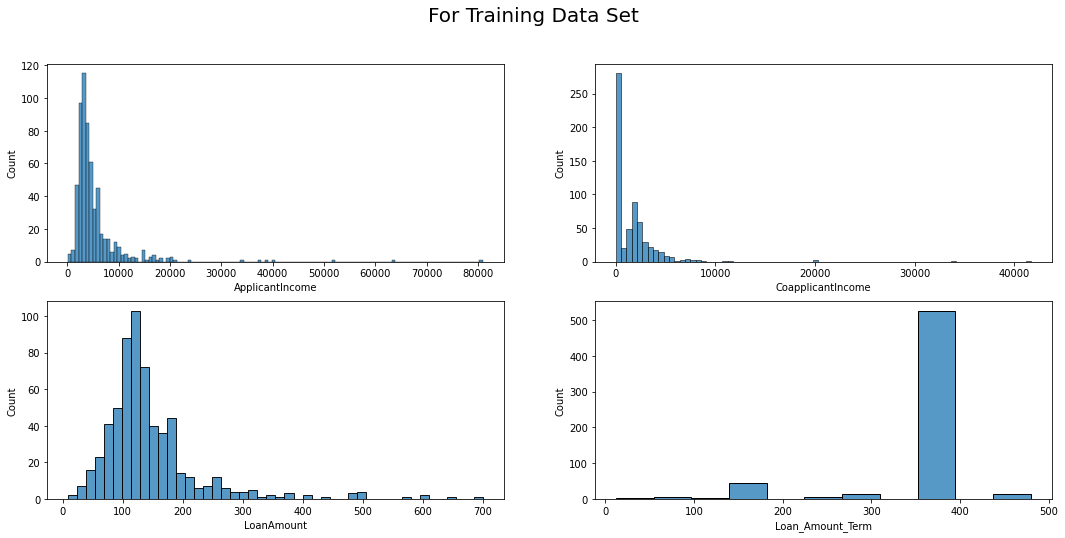

In [34]:
# Histogram of training data for continues variable.
hist_plot(train_df,"For Training Data Set")

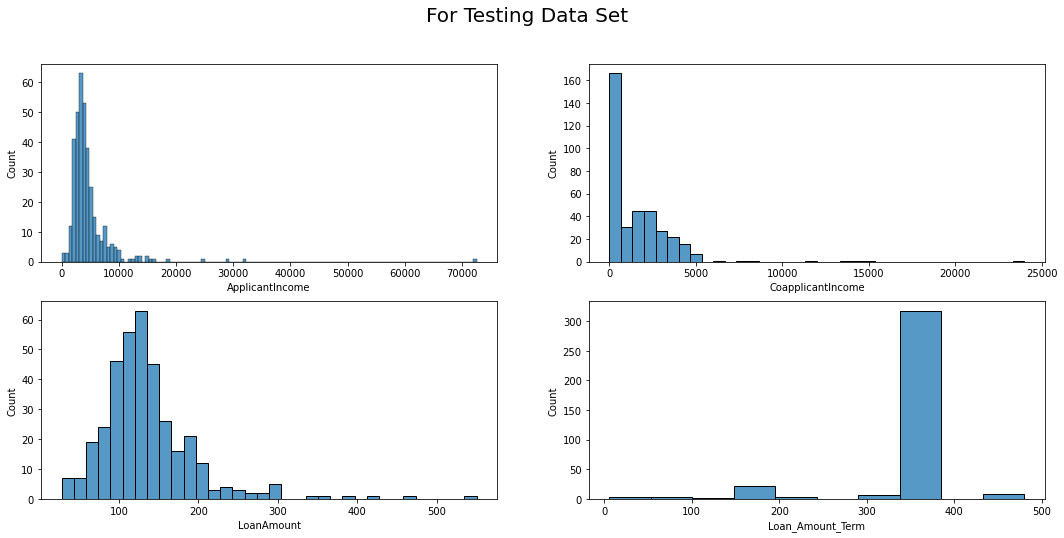

In [35]:
# Histogram of training data for continues variable.
hist_plot(test_df,"For Testing Data Set")

**From the above plots we can see there are some outlier and some biasness. So to normalise it**
- Make "Loan_Amount_Term" into different Bins and encode it.
- Apply ***SandardScaler*** for "ApplicantIncome", "CoapplicantIncome" and "LoanAmount"  .


In [36]:
#Create the new features from loan amount terms
def process_loan_term_train():
    train_df['Short_Term'] = train_df['Loan_Amount_Term'].map(lambda x: 1 if x<=150 else 0)
    train_df['Medium_Term'] = train_df['Loan_Amount_Term'].map(lambda x: 1 if x>150 and x<=300 else 0)
    train_df['Long_Term'] = train_df['Loan_Amount_Term'].map(lambda x: 1 if x>300 and x<=400 else 0)
    train_df['Very_Long_Term'] = train_df['Loan_Amount_Term'].map(lambda x: 1 if x>400 else 0)
    train_df.drop('Loan_Amount_Term', axis=1, inplace=True)
process_loan_term_train()

**Do the same things for Testing dataset**

In [37]:
#Create the new features from loan amount terms
def process_loan_term_test():
    test_df['Short_Term'] = test_df['Loan_Amount_Term'].map(lambda x: 1 if x<=150 else 0)
    test_df['Medium_Term'] = test_df['Loan_Amount_Term'].map(lambda x: 1 if x>150 and x<=300 else 0)
    test_df['Long_Term'] = test_df['Loan_Amount_Term'].map(lambda x: 1 if x>300 and x<=400 else 0)
    test_df['Very_Long_Term'] = test_df['Loan_Amount_Term'].map(lambda x: 1 if x>400 else 0)
    test_df.drop('Loan_Amount_Term', axis=1, inplace=True)
process_loan_term_test()

### 4. Standardise the continues data for Training and Testing 

In [38]:
# Now scale the continues feature to standardise the data
scaler = StandardScaler() 

for feature in ["ApplicantIncome", "CoapplicantIncome" , "LoanAmount"]: 
    train_df[feature] = scaler.fit_transform(train_df[[feature]])
    test_df[feature] = scaler.fit_transform(test_df[[feature]])


In [39]:
train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,Short_Term,Medium_Term,Long_Term,Very_Long_Term
0,1,0,-0.737806,0,0,0.072991,-0.554487,-0.211241,1.0,1.223298,1,0,0,1,0
1,1,1,0.253470,0,0,-0.134412,-0.038732,-0.211241,1.0,-1.318513,0,0,0,1,0
2,1,1,-0.737806,0,1,-0.393747,-0.554487,-0.948996,1.0,1.223298,1,0,0,1,0
3,1,1,-0.737806,1,0,-0.462062,0.251980,-0.306435,1.0,1.223298,1,0,0,1,0
4,1,0,-0.737806,0,0,0.097728,-0.554487,-0.056551,1.0,1.223298,1,0,0,1,0


In [40]:
test_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Short_Term,Medium_Term,Long_Term,Very_Long_Term
0,1,1,-0.758222,0,0,0.186461,-0.673335,-0.426780,1.0,1.118764,0,0,1,0
1,1,1,0.181871,0,0,-0.352692,-0.029848,-0.163953,1.0,1.118764,0,0,1,0
2,1,1,1.121964,0,0,0.039641,0.098849,1.183033,1.0,1.118764,0,0,1,0
3,1,1,1.121964,0,0,-0.502774,0.418877,-0.591047,1.0,1.118764,0,0,1,0
4,1,0,-0.758222,1,0,-0.311909,-0.673335,-0.952433,1.0,1.118764,0,0,1,0


**###########################################################################################################**

# Machine Learning Model Building Approaches
### 5.1. Baseline Model using DABL SimpleClassifier()

In [41]:
#Run DABL SimpleClassifier
All_Clf = dabl.SimpleClassifier(random_state=0).fit(train_df,target_col="Loan_Status")
All_Clf

Running DummyClassifier(strategy='prior')
accuracy: 0.687 average_precision: 0.313 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.407
=== new best DummyClassifier(strategy='prior') (using recall_macro):
accuracy: 0.687 average_precision: 0.313 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.407

Running GaussianNB()
accuracy: 0.785 average_precision: 0.228 roc_auc: 0.738 recall_macro: 0.695 f1_macro: 0.713
=== new best GaussianNB() (using recall_macro):
accuracy: 0.785 average_precision: 0.228 roc_auc: 0.738 recall_macro: 0.695 f1_macro: 0.713

Running MultinomialNB()
accuracy: 0.810 average_precision: 0.231 roc_auc: 0.736 recall_macro: 0.705 f1_macro: 0.729
=== new best MultinomialNB() (using recall_macro):
accuracy: 0.810 average_precision: 0.231 roc_auc: 0.736 recall_macro: 0.705 f1_macro: 0.729

Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.810 average_precision: 0.255 roc_auc: 0.705 recall_macro: 0.705 f1_macro: 0.729
Running DecisionTreeClassifie

SimpleClassifier(random_state=0, refit=True, shuffle=True, type_hints=None,
                 verbose=1)

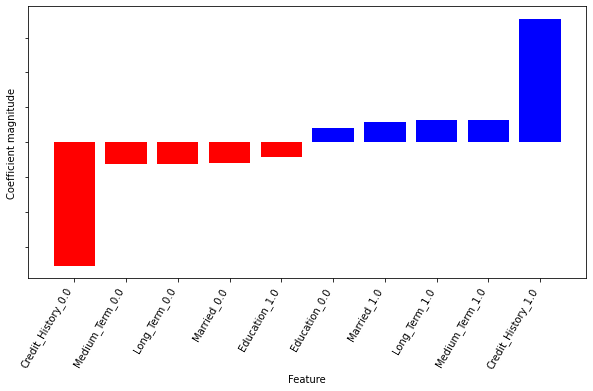

In [42]:
#Feature Importance using DABL on Best Model: Logistic Regression
dabl.explain(All_Clf) 

### 5.2. Ensemble Learning Model: Random Forest
- Training Data: 70%
- Test Data: 30%

In [58]:
# create the X and y for training dataset
X_feature = train_df.drop(columns="Loan_Status")
y_target = train_df["Loan_Status"]

# Split the dataset
X_train,X_test,y_train,y_test = train_test_split(X_feature,y_target,random_state = 21,test_size=0.3)

In [59]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1, verbose = 1)
# Fit on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [60]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 200
Average maximum depth 16


In [61]:
# Accuracy of the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("Training Score: {:.2%} ".format(accuracy_score(y_train,train_pred)))
print("Testing Score:{:.2%}".format(accuracy_score(y_test,test_pred)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Training Score: 100.00% 
Testing Score:78.92%


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


              Feature  Importance
8      Credit_History    0.230450
5     ApplicantIncome    0.201844
7          LoanAmount    0.193740
6   CoapplicantIncome    0.130599
2          Dependents    0.053157
9       Property_Area    0.047967
1             Married    0.031130
3           Education    0.027323
0              Gender    0.018705
4       Self_Employed    0.018190
12          Long_Term    0.018019
11        Medium_Term    0.013232
13     Very_Long_Term    0.011089
10         Short_Term    0.004555


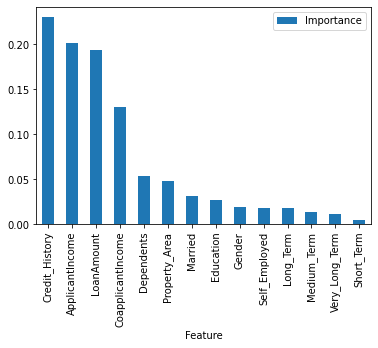

In [62]:
# Extract feature importances
features = pd.DataFrame()
features['Feature'] = X_train.columns
features['Importance'] = model.feature_importances_
features.sort_values(by=['Importance'], ascending=False, inplace=True)
print(features)
features.set_index('Feature', inplace=True)
features.plot(kind='bar');

In [70]:
# Accuracy matrix, F1 Score, recall score
print("Accuracy Score: {:.2%}".format(accuracy_score(y_test,test_pred)))
print("Classification Report:\n",classification_report(y_test,test_pred))

#confusion Matrix
CM = confusion_matrix(y_test,test_pred)
print("\nConfusion Matrix:\n\n",CM)

Accuracy Score: 78.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.53      0.60        55
           1       0.82      0.90      0.86       130

    accuracy                           0.79       185
   macro avg       0.75      0.71      0.73       185
weighted avg       0.78      0.79      0.78       185


Confusion Matrix:

 [[ 29  26]
 [ 13 117]]


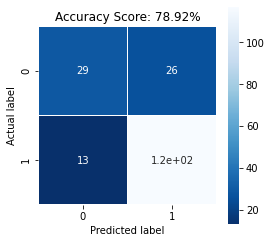

In [64]:
plt.figure(figsize=(4,4))
sns.heatmap(CM, annot=True, linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score: {:.2%}'.format(accuracy_score(y_test,test_pred))
plt.title(title, size = 12)
plt.show()

**##################################################################################################################**

### 6.1 Running Grid Search on Multiple Algorithms with Hypertuning Parameters

In [65]:
# Defining RFC(random forest classifier) model hyper-parameters
rfc_models = RandomForestClassifier()
rfc_params = {'n_estimators': [75,100,120],  
                      'max_depth': [25,30,40],
                      'min_samples_leaf': [2,4,6],
                      'min_samples_split': [2,4,6]}

# Defining LR(logistic regression) model hyper-parameters
lr_models = LogisticRegression()
lr_params = {'C': [0.1, 0.01],
                     'tol': [0.001, 0.01],
                     'max_iter': [1000, 2000]}

# Defining GBC(gradient boosting classifier) model hyper-parameters
gbc_models = GradientBoostingClassifier()
gbc_params = {'n_estimators': [25,50,100], 
              'learning_rate':[0.1,0.2,0.3],
                      'max_depth': [20,25,30],
                      'min_samples_leaf': [1,2,4],
                      'min_samples_split': [3,4,6]}


grid = zip([rfc_models,lr_models,gbc_models],[rfc_params,lr_params,gbc_params])

best_clf = None
# perform grid search and select the model with best cv set scores
for model_pipeline, param in grid:
    temp = GridSearchCV(model_pipeline, param_grid=param, cv=3, n_jobs=-1)
    temp.fit(X_train, y_train)
    if best_clf is None:
        best_clf = temp
    else:
        if temp.best_score_ > best_clf.best_score_:
            best_clf = temp
            
print ("Best CV Score: ",best_clf.best_score_)
print ("\nModel Parameters: ",best_clf.best_params_)
print("\nBest Estimator:\n",best_clf.best_estimator_)

Best CV Score:  0.8041958041958042

Model Parameters:  {'max_depth': 25, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 100}

Best Estimator:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


### 6.2 Best model prediction and evaluation

#### So the best model is RandomForest Classifier 

In [72]:
y_pred = best_clf.predict(X_test)

# Accuracy matrix, F1 Score, recall score
print("Accuracy Score with Best Model: {:.2%}".format(accuracy_score(y_test,y_pred)))
print("Classification Report:\n",classification_report(y_test,y_pred))

#confusion Matrix
CM_best = confusion_matrix(y_test,y_pred)
print("\nConfusion Matrix:\n",CM_best)

Accuracy Score with Best Model: 82.70%
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.49      0.63        55
           1       0.82      0.97      0.89       130

    accuracy                           0.83       185
   macro avg       0.84      0.73      0.76       185
weighted avg       0.83      0.83      0.81       185


Confusion Matrix:
 [[ 27  28]
 [  4 126]]


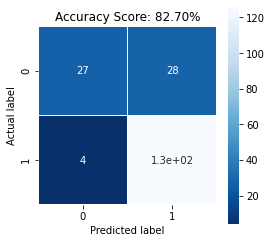

In [67]:
plt.figure(figsize=(4,4))
sns.heatmap(CM_best, annot=True, linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score: {:.2%}'.format(accuracy_score(y_test,y_pred))
plt.title(title, size = 12)
plt.show()

In [68]:
#view the actual and predicted value of training data
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(15)

,Actual,Predicted
452,0,0
391,1,1
529,1,1
594,1,1
448,0,0
465,1,1
77,0,1
244,1,1
353,0,0
453,1,0


**#################################################################################################################**

### 7. Predict the target value with the Test dataset

In [73]:
LoanStatus_TestData = best_clf.predict(test_df)
LoanStatus_TestData

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,